In [1]:
import numpy as np
import pandas as pd


data = pd.read_csv("creditcard.csv")

data.head()

data['Class'].value_counts()

len(data['Class'])

print("percentage of fraudulent data instances: {}".format(data['Class'].value_counts()[1] *100 /len(data['Class'])))
print("percentage of normal data instances: {}".format(data['Class'].value_counts()[0] *100 /len(data['Class'])))

# Rescaling the data

from sklearn.preprocessing import RobustScaler

rs = RobustScaler()

data['scaled_amount'] = rs.fit_transform(data['Amount'].values.reshape(-1, 1))
data['scaled_time'] = rs.fit_transform(data['Time'].values.reshape(-1, 1))

data.drop(['Amount', 'Time'], axis = 1, inplace = True)

from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression

X = data.drop(['Class'], axis = 1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, 
                                                    stratify = y)

print(X_train.shape, y_train.shape)
print(y_train.value_counts())

### A lot of data imbalance. We'll use SMOTE to oversample the minority class

# pip install imblearn --user

# from imblearn.over_sampling import SMOTE

# print("Shape of the X_train before applying SMOTE is: ", X_train.shape)
# print("Shape of the y_train data before applying SMOTE is: ", y_train.shape)
# print("Shape of the X_test before applying SMOTE is: ", X_test.shape)
# print("Shape of the y_test before applying SMOTE is: ", y_test.shape)
# print()
# print("Before applying SMOTE the count of the fraud cases are: ", y_train.value_counts().values[1])
# print("Before applying SMOTE the count of the non-fraud cases are: ", y_train.value_counts().values[0])

# sm = SMOTE(random_state = 2)
# X_train_s, y_train_s = sm.fit_sample(X_train, y_train.ravel())

# print("Shape of the X_train after applying SMOTE is: ", X_train_s.shape)
# print("Shape of the y_train data after applying SMOTE is: ", y_train_s.shape)
# print()
# print("After applying SMOTE the count of the fraud cases are: ", sum(y_train_s == 1))
# print("After applying SMOTE the count of the non-fraud cases are: ", sum(y_train_s == 0))
# print("After applying SMOTE the percentage of the fraud cases are: ", sum(y_train_s == 1)/ len(y_train_s) * 100.0)
# print("After applying SMOTE the percentage of the non-fraud cases are: ", sum(y_train_s == 0)/ len(y_train_s) * 100.0)

percentage of fraudulent data instances: 0.1727485630620034
percentage of normal data instances: 99.827251436938
(227845, 30) (227845,)
0    227451
1       394
Name: Class, dtype: int64


In [8]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from collections import Counter

In [3]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [4]:
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_undersample, y_train_undersample = undersample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y_train_undersample))

Counter({0: 394, 1: 394})


In [5]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [6]:
iht = InstanceHardnessThreshold(sampling_strategy='majority', random_state=42)
X_train_res, y_train_res = iht.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))

Resampled dataset shape Counter({0: 222288, 1: 394})


In [6]:
all_dataset=dict()


In [10]:
all_results=[]

In [3]:
 def training_testing_function(X,y,name):
        corr = X.corr()
        columns = np.full((corr.shape[0],), True, dtype=bool)
        for i in range(corr.shape[0]):
            for j in range(i+1, corr.shape[0]):
                if corr.iloc[i,j] >= 0.9:
                    if columns[j]:
                        columns[j] = False
        selected_columns = X.columns[columns]
        X = X[selected_columns]


        rfc = RandomForestClassifier();

        # fit random forest classifier on the training set
        rfc.fit(X, y.values.ravel());
        # extract important features
        score = np.round(rfc.feature_importances_,3)

        importances = pd.DataFrame({'feature':X.columns,'importance':score})
        importances = importances.sort_values('importance',ascending=False).set_index('feature')

        final_features=list(importances[:20].index)

        X=X[final_features]

        # Train KNeighborsClassifier Model
        KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
        # KNN_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel()); 

        # Train LogisticRegression Model
        LGR_Classifier = LogisticRegression(multi_class='auto', random_state=1,solver='lbfgs',max_iter=400)
        # LGR_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());

        # Train Gaussian Naive Baye Model
        GNB_Classifier = GaussianNB()
        # GNB_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel())

        # Train Decision Tree Model
        DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
        # DTC_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());

        # Train RandomForestClassifier Model
        #RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
        #RF_Classifier.fit(X_train, Y_train);  

        # Train SVM Model
        #SVC_Classifier = SVC(random_state=0)
        #SVC_Classifier.fit(X_train, Y_train)

        ## Train Ensemble Model (This method combines all the individual models above except RandomForest)
        combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
                         ('KNeighborsClassifier', KNN_Classifier), 
                         ('LogisticRegression', LGR_Classifier)
                        ]
        VC =  VotingClassifier(estimators = combined_model,voting = 'soft')
        VC.fit(X, y.values.ravel());

        models = []
        #models.append(('SVM Classifier', SVC_Classifier))
        # models.append(('Naive Baye Classifier', GNB_Classifier))
        # models.append(('Decision Tree Classifier', DTC_Classifier))
        #models.append(('RandomForest Classifier', RF_Classifier))
        # models.append(('KNeighborsClassifier', KNN_Classifier))
        # models.append(('LogisticRegression', LGR_Classifier))
        models.append(('VotingClassifier', VC))

        for i, v in models:
    #         accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X_test[final_features]))
    #         confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X_test[final_features]))
    #         classification = metrics.classification_report(y_test.values.ravel(), v.predict(X_test[final_features]))
            f1 = metrics.f1_score(y_test.values.ravel(),v.predict(X_test[final_features]))
            all_results.append((name,f1))
            print("{} Completed".format(name))
    #         print('============================== {} Model Test Results =============================='.format(i))
    #         print()
    #         print ("Model Accuracy:" "\n", accuracy)
    #         print()
    #         print("Confusion matrix:" "\n", confusion_matrix)
    #         print()
    #         print("Classification report:" "\n", classification) 
    #         print()        






### Working with random undersampled data

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(X_train_undersample.corr())
plt.show()

<Figure size 640x480 with 2 Axes>

In [8]:
 ### Removing one of the features having high correlation with other feature

In [9]:
corr = X_train_undersample.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X_train.columns[columns]
X_train_undersample = X_train_undersample[selected_columns]

In [10]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X_train_undersample, y_train_undersample.values.ravel());
# extract important features
score = np.round(rfc.feature_importances_,3)


In [11]:
import matplotlib.pyplot as plt

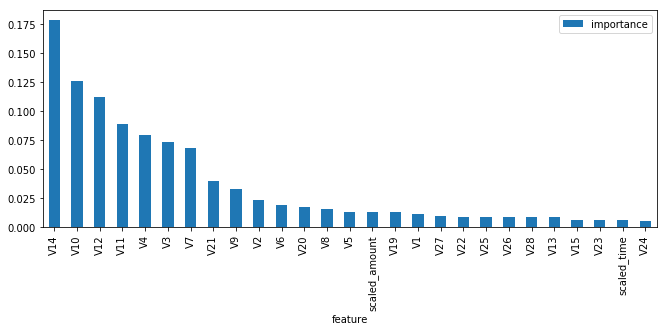

In [12]:
importances = pd.DataFrame({'feature':X_train_undersample.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [13]:
final_features=list(importances[:20].index)

In [14]:
final_features


['V14',
 'V10',
 'V12',
 'V11',
 'V4',
 'V3',
 'V7',
 'V21',
 'V9',
 'V2',
 'V6',
 'V20',
 'V8',
 'V5',
 'scaled_amount',
 'V19',
 'V1',
 'V27',
 'V22',
 'V25']

In [15]:
X_train_undersample=X_train_undersample[final_features]

In [16]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train_undersample, y_train_undersample.values.ravel()); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(multi_class='auto',n_jobs=-1, random_state=0,solver='lbfgs')
LGR_Classifier.fit(X_train_undersample, y_train_undersample.values.ravel());

# Train Gaussian Naive Baye Model
GNB_Classifier = GaussianNB()
GNB_Classifier.fit(X_train_undersample, y_train_undersample.values.ravel())
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train_undersample, y_train_undersample.values.ravel());
            
# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train, Y_train);  

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train, Y_train)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                 ('Decision Tree Classifier', DTC_Classifier), 
                 ('KNeighborsClassifier', KNN_Classifier), 
                 ('LogisticRegression', LGR_Classifier)
                ]
VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
VotingClassifier.fit(X_train_undersample, y_train_undersample.values.ravel());

In [17]:
from sklearn import metrics

models = []
#models.append(('SVM Classifier', SVC_Classifier))
models.append(('Naive Baye Classifier', GNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
#models.append(('RandomForest Classifier', RF_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))
models.append(('VotingClassifier', VotingClassifier))

for i, v in models:
    accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X_test[final_features]))
    confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X_test[final_features]))
    classification = metrics.classification_report(y_test.values.ravel(), v.predict(X_test[final_features]))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        



============================== Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.9753695446086865

Confusion matrix:
 [[55482  1382]
 [   21    77]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.05      0.79      0.10        98

    accuracy                           0.98     56962
   macro avg       0.53      0.88      0.54     56962
weighted avg       1.00      0.98      0.99     56962



============================== Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9203855201713423

Confusion matrix:
 [[52338  4526]
 [    9    89]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.91      0.04        98

    accuracy                           0.92     56962
   macro avg     

### Working with IHT data

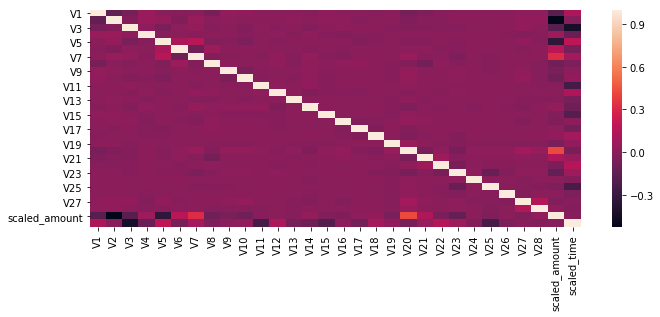

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(X_train_res.corr())
plt.show()

In [20]:
 ### Removing one of the features having high correlation with other feature

In [21]:
corr = X_train_res.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X_train.columns[columns]
X_train_res = X_train_res[selected_columns]

In [22]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X_train_res, y_train_res.values.ravel());
# extract important features
score = np.round(rfc.feature_importances_,3)


In [23]:
import matplotlib.pyplot as plt

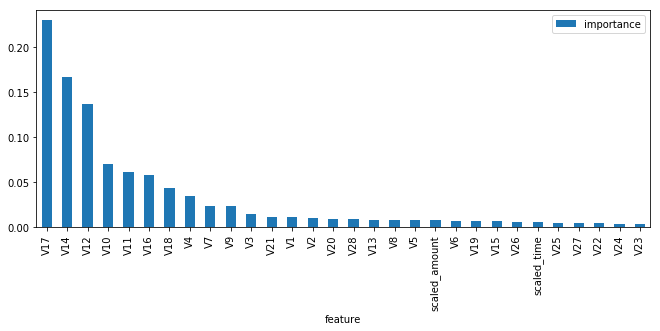

In [24]:
importances = pd.DataFrame({'feature':X_train_res.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [25]:
final_features=list(importances[:20].index)

In [26]:
final_features


['V17',
 'V14',
 'V12',
 'V10',
 'V11',
 'V16',
 'V18',
 'V4',
 'V7',
 'V9',
 'V3',
 'V21',
 'V1',
 'V2',
 'V20',
 'V28',
 'V13',
 'V8',
 'V5',
 'scaled_amount']

In [27]:
X_train_res=X_train_res[final_features]

In [29]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train_res, y_train_res.values.ravel()); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(multi_class='auto', random_state=1,solver='lbfgs')
LGR_Classifier.fit(X_train_res, y_train_res.values.ravel());

# Train Gaussian Naive Baye Model
GNB_Classifier = GaussianNB()
GNB_Classifier.fit(X_train_res, y_train_res.values.ravel())
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train_res, y_train_res.values.ravel());
            
# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train, Y_train);  

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train, Y_train)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                 ('Decision Tree Classifier', DTC_Classifier), 
                 ('KNeighborsClassifier', KNN_Classifier), 
                 ('LogisticRegression', LGR_Classifier)
                ]
VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft')
VotingClassifier.fit(X_train_res, y_train_res.values.ravel());

In [30]:
from sklearn import metrics
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

models = []
#models.append(('SVM Classifier', SVC_Classifier))
models.append(('Naive Baye Classifier', GNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
#models.append(('RandomForest Classifier', RF_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))
models.append(('VotingClassifier', VotingClassifier))

for i, v in models:
    accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X_test[final_features]))
    confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X_test[final_features]))
    classification = metrics.classification_report(y_test.values.ravel(), v.predict(X_test[final_features]))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        



============================== Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.9751413222850321

Confusion matrix:
 [[55466  1398]
 [   18    80]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.05      0.82      0.10        98

    accuracy                           0.98     56962
   macro avg       0.53      0.90      0.54     56962
weighted avg       1.00      0.98      0.99     56962



============================== Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9986306660580738

Confusion matrix:
 [[56806    58]
 [   20    78]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.57      0.80      0.67        98

    accuracy                           1.00     56962
   macro avg     

#### 3. Cluster Centroid

In [31]:
from imblearn.under_sampling import ClusterCentroids

In [32]:
X_cluster_centroids,y_cluster_centroids = ClusterCentroids().fit_resample(X_train,y_train)

In [33]:
all_dataset["X_cluster_centroids"],all_dataset["y_cluster_centroids"] = X_cluster_centroids,y_cluster_centroids

In [34]:
training_testing_function(all_dataset["X_cluster_centroids"],all_dataset["y_cluster_centroids"],"Cluster centroids")

Cluster centroids Completed


In [36]:
all_results

[('SMOTE', 0.7545454545454545),
 ('ADASYN', 0.6259541984732825),
 ('Borderline SMOTE', 0.7843137254901962),
 ('SVM SMOTE', 0.7839195979899498),
 ('Cluster centroids', 0.3110307414104882)]

#### 4. Near Miss

In [39]:
from imblearn.under_sampling import NearMiss

In [40]:
all_dataset['X_near_miss'],all_dataset['y_near_miss'] = NearMiss().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_near_miss'],all_dataset['y_near_miss'],"Near Miss")

Near Miss Completed


In [41]:
all_results

[('SMOTE', 0.7545454545454545),
 ('ADASYN', 0.6259541984732825),
 ('Borderline SMOTE', 0.7843137254901962),
 ('SVM SMOTE', 0.7839195979899498),
 ('Cluster centroids', 0.3110307414104882),
 ('Near Miss', 0.007315406567788095)]

#### 5. One Sided Selection

In [43]:
from imblearn.under_sampling import OneSidedSelection

In [44]:
all_dataset['X_one_sided_selection'],all_dataset['y_one_sided_selection'] = OneSidedSelection().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_one_sided_selection'],all_dataset['y_one_sided_selection'],"One Sided Selection")

One Sided Selection Completed


In [45]:
all_results

[('SMOTE', 0.7545454545454545),
 ('ADASYN', 0.6259541984732825),
 ('Borderline SMOTE', 0.7843137254901962),
 ('SVM SMOTE', 0.7839195979899498),
 ('Cluster centroids', 0.3110307414104882),
 ('Near Miss', 0.007315406567788095),
 ('One Sided Selection', 0.7789473684210526)]

#### 6. Tomek Links

In [4]:
from imblearn.under_sampling import TomekLinks

In [ ]:
all_dataset['X_tomek_links'],all_dataset['y_tomek_links'] = TomekLinks().fit_resample(X_train,y_train)


In [11]:
training_testing_function(all_dataset['X_tomek_links'],all_dataset['y_tomek_links'],"Tomek Links")

Tomek Links Completed


In [12]:
all_results

[('Tomek Links', 0.7914438502673796)]

### Oversampling data

#### 1. Random Oversampling

In [3]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from collections import Counter

In [17]:
ros = RandomOverSampler(random_state=0)
X_train_random_oversampled, y_train_random_oversampled = ros.fit_resample(X_train, y_train)
from collections import Counter
print(sorted(Counter(y_train_random_oversampled).items()))

[(0, 227451), (1, 227451)]


In [18]:
corr = X_train_random_oversampled.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X_train_random_oversampled.columns[columns]
X_train_random_oversampled = X_train_random_oversampled[selected_columns]


rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());
# extract important features
score = np.round(rfc.feature_importances_,3)

importances = pd.DataFrame({'feature':X_train_random_oversampled.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

final_features=list(importances[:20].index)

X_train_random_oversampled=X_train_random_oversampled[final_features]

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
# KNN_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel()); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(multi_class='auto', random_state=1,solver='lbfgs')
# LGR_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());

# Train Gaussian Naive Baye Model
GNB_Classifier = GaussianNB()
# GNB_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel())
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
# DTC_Classifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());
            
# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train, Y_train);  

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train, Y_train)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                 ('Decision Tree Classifier', DTC_Classifier), 
                 ('KNeighborsClassifier', KNN_Classifier), 
                 ('LogisticRegression', LGR_Classifier)
                ]
VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft')
VotingClassifier.fit(X_train_random_oversampled, y_train_random_oversampled.values.ravel());

models = []
#models.append(('SVM Classifier', SVC_Classifier))
# models.append(('Naive Baye Classifier', GNB_Classifier))
# models.append(('Decision Tree Classifier', DTC_Classifier))
#models.append(('RandomForest Classifier', RF_Classifier))
# models.append(('KNeighborsClassifier', KNN_Classifier))
# models.append(('LogisticRegression', LGR_Classifier))
models.append(('VotingClassifier', VotingClassifier))

for i, v in models:
    accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X_test[final_features]))
    confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X_test[final_features]))
    classification = metrics.classification_report(y_test.values.ravel(), v.predict(X_test[final_features]))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        







============================== VotingClassifier Model Test Results ==============================

Model Accuracy:
 0.9993153330290369

Confusion matrix:
 [[56845    19]
 [   20    78]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.80      0.80        98

    accuracy                           1.00     56962
   macro avg       0.90      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962




#### 2. SMOTE

In [12]:
from imblearn.over_sampling import SMOTE, ADASYN
X_smote, y_smote = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_smote).items()))



[(0, 227451), (1, 227451)]


In [13]:

all_dataset['X_smote'],all_dataset['y_smote'] = X_smote,y_smote

In [14]:
all_results=[]

In [16]:
training_testing_function(all_dataset['X_smote'],all_dataset['y_smote'],"SMOTE")

SMOTE Completed


In [17]:
all_results

[('SMOTE', 0.7545454545454545)]

#### 3. ADASYN

In [20]:
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_adasyn).items()))

[(0, 227451), (1, 227448)]


In [21]:
all_dataset['X_adasyn'],all_dataset['y_adasyn']=X_adasyn,y_adasyn

In [22]:
training_testing_function(all_dataset['X_adasyn'],all_dataset['y_adasyn'],"ADASYN")

ADASYN Completed


In [23]:
all_results

[('SMOTE', 0.7545454545454545), ('ADASYN', 0.6259541984732825)]

#### 4. Variations of SMOTE

In [24]:
from imblearn.over_sampling import BorderlineSMOTE,SVMSMOTE,KMeansSMOTE

In [29]:
X_borderline_smote,y_borderline_smote = BorderlineSMOTE().fit_resample(X_train,y_train)
X_svm_smote,y_svm_smote = SVMSMOTE().fit_resample(X_train,y_train)
# X_kmeans_smote,y_kmeans_smote = KMeansSMOTE().fit_resample(X_train,y_train)

all_dataset["X_borderline_smote"],all_dataset["y_borderline_smote"]= X_borderline_smote,y_borderline_smote
all_dataset["X_svm_smote"],all_dataset["y_svm_smote"]= X_svm_smote,y_svm_smote
# all_dataset["X_kmeans_smote"],all_dataset["y_kmeans_smote"]= X_kmeans_smote,y_kmeans_smote

training_testing_function(all_dataset["X_borderline_smote"],all_dataset["y_borderline_smote"],"Borderline SMOTE")
training_testing_function(all_dataset["X_svm_smote"],all_dataset["y_svm_smote"],"SVM SMOTE")
# training_testing_function(all_dataset["X_kmeans_smote"],all_dataset["y_kmeans_smote"],"KMeans SMOTE")



Borderline SMOTE Completed
SVM SMOTE Completed


In [30]:
all_results

[('SMOTE', 0.7545454545454545),
 ('ADASYN', 0.6259541984732825),
 ('Borderline SMOTE', 0.7843137254901962),
 ('SVM SMOTE', 0.7839195979899498)]

### Combination of Undersampling and Oversampling

#### 1. SMOTETomek

In [13]:
from imblearn.combine import SMOTETomek

In [14]:
all_dataset['X_smote_tomek'],all_dataset['y_smote_tomek'] = SMOTETomek().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_smote_tomek'],all_dataset['y_smote_tomek'],"SMOTE Tomek")

SMOTE Tomek Completed


In [15]:
all_results

[('Tomek Links', 0.7914438502673796), ('SMOTE Tomek', 0.7248908296943231)]